In [1]:
import git

In [2]:
import os
import math
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import image

In [30]:
import re
import itertools

regex = re.compile(', freq:\s\d\S\d+')

In [3]:
import torch

In [4]:
import sys
print(sys.executable)

C:\Users\Ksenia\jupyter310\Scripts\python.exe


In [5]:
PATH_TO_EPDE = "C:\\Users\\Ksenia\\jupyter310\\Lib\\site-packages\\epde\\"
sys.path.append(PATH_TO_EPDE)

In [6]:
import epde

In [7]:
from epde.control import ControlExp, ConstrLocation, ConditionalLoss, ControlConstrEq, ControlConstrNEq
from epde.interface.prepared_tokens import DerivSignFunction

In [8]:
from epde.interface.interface import EpdeMultisample

In [9]:
file_path = Path(r'C:\Users\Ksenia\NSS\ODE_projects\diffSDE')
npy_file = file_path / 'trajectories' 

In [10]:
epde.__dict__

{'__name__': 'epde',
 '__doc__': None,
 '__package__': 'epde',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1c3ed9defb0>,
 '__spec__': ModuleSpec(name='epde', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001C3ED9DEFB0>, origin='C:\\Users\\Ksenia\\jupyter310\\lib\\site-packages\\epde\\__init__.py', submodule_search_locations=['C:\\Users\\Ksenia\\jupyter310\\lib\\site-packages\\epde']),
 '__path__': ['C:\\Users\\Ksenia\\jupyter310\\lib\\site-packages\\epde'],
 '__file__': 'C:\\Users\\Ksenia\\jupyter310\\lib\\site-packages\\epde\\__init__.py',
 '__cached__': 'C:\\Users\\Ksenia\\jupyter310\\lib\\site-packages\\epde\\__pycache__\\__init__.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins

In [11]:
data = np.load(npy_file)

In [12]:
data

array([[[ 0.597918  ,  0.26773056, -0.17751566,  0.7679116 ,
          0.02206779],
        [ 0.6807914 ,  0.13959253, -0.30000806,  1.0177046 ,
          0.08735609],
        [ 0.95052767,  0.08733295, -0.24366714,  1.4993129 ,
          0.13928908],
        ...,
        [ 1.5154135 , -0.49229857,  0.24978463,  0.8268385 ,
         -0.03140748],
        [ 1.6737516 , -0.45002565,  0.19869234,  0.6334537 ,
         -0.13154045],
        [ 1.4536674 , -0.6653154 ,  0.6474414 ,  0.87073416,
         -0.26066834]],

       [[-1.5755044 , -1.5675732 ,  1.3994243 , -0.20776045,
          0.732044  ],
        [-1.8215969 , -1.6350925 ,  1.4144238 ,  0.0337607 ,
          0.42076606],
        [-2.0797691 , -1.3580676 ,  1.0207247 , -0.3178487 ,
          0.6506471 ],
        ...,
        [-1.4450198 , -1.0323315 ,  0.8399755 , -0.34161997,
         -1.218419  ],
        [-1.6417465 , -1.2633455 ,  0.67276955, -0.33578223,
         -1.4809238 ],
        [-1.3905765 , -1.370883  ,  0.510686  , 

In [13]:
data_trajectories = [data[i] for i in range(data.shape[0])] 

In [14]:
init_conditions = data[:, 0, :]
features = [f'feature_{i}' for i in range(init_conditions.shape[1])]
init_df = pd.DataFrame(init_conditions, columns=features)
print(init_df.describe())

          feature_0     feature_1     feature_2     feature_3     feature_4
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.103961      0.093010      0.093589      0.099284      0.116630
std        0.990251      1.006748      1.005488      1.001555      1.011966
min       -4.107175     -3.622948     -4.234232     -3.543763     -3.598707
25%       -0.567979     -0.586538     -0.587757     -0.582748     -0.565645
50%        0.102548      0.088178      0.088697      0.098208      0.121467
75%        0.765603      0.761413      0.776162      0.765511      0.805740
max        4.250378      4.222790      4.204389      3.625981      5.042685


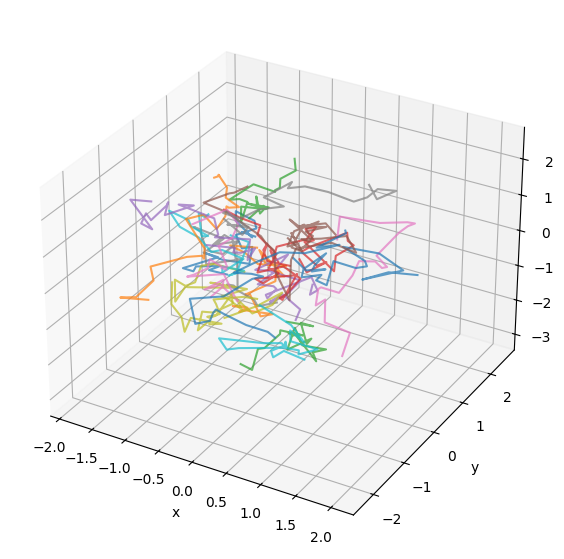

In [15]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
num_trajectories = 21
indices = np.random.choice(data.shape[0], num_trajectories, replace=False)
for idx in indices:
    traj = data[idx]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [16]:
trajectories = [data[i] for i in range(data.shape[0])]


In [17]:
trajectories[0].shape

(21, 5)

In [18]:
len(trajectories)

10000

In [19]:
from typing import List

In [20]:
def get_additional_token_families(ctrl, ctrl_net: torch.nn.Sequential, device = 'cpu'):
    angle_trig_tokens = VarTrigTokens('phi', max_power=2, freq_center=1.)
    sgn_tokens = DerivSignFunction(token_type = 'velocity_signum', var_name = 'y', token_labels=['sign(dy/dx1)',],
                                   deriv_solver_orders = [[0,],])
    control_var_tokens = epde.interface.prepared_tokens.ControlVarTokens(sample = ctrl, arg_var = [(0, [None,]), (1, [None,]),
                                                                                                   (0, [0,]), (1, [0,])],
                                                                         device = device, ann = ctrl_net)
    return [angle_trig_tokens, sgn_tokens, control_var_tokens]   

In [21]:
def epde_multisample_discovery(t: List[np.ndarray], x0: List[np.ndarray], x1: List[np.ndarray],x2: List[np.ndarray],x3: List[np.ndarray],x4: List[np.ndarray], 
                               derivs: List[np.ndarray]=None,  diff_method: str = 'poly'):
    
#     print(len(t), len(x0), len(x1), len(x2), len(x3), len(x4))
    
    samples = [[t[i], [x0[i], x1[i], x2[i], x3[i], x4[i]]] for i in range(len(t))]  # t[i], [
#     print([sample[0].shape for sample in samples])
    epde_search_obj = epde.EpdeMultisample(data_samples=samples, use_solver = False,
                                           boundary = 0, verbose_params = {'show_iter_idx' : True})

    if diff_method == 'ANN':
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 100})
    elif diff_method == 'poly':
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 4}) 
    elif diff_method == 'FD':
        epde_search_obj.set_preprocessor(default_preprocessor_type='FD',
                                         preprocessor_kwargs={}) 
    else:
        raise ValueError('Incorrect preprocessing tool selected.')
        
    eps = 5e-7
    popsize = 12
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=30)

    factors_max_number = {'factors_num' : [1, 2, 3,], 'probas' : [0.2, 0.65, 0.15]}

    epde_search_obj.fit(samples = samples, variable_names = ['u1', 'u2', 'u3', 'u4', 'u5'], max_deriv_order = (2,),
                            equation_terms_max_number = 15, data_fun_pow = 2, deriv_fun_pow=2, derivs = derivs,
#                             additional_tokens = get_additional_token_families(ctrl=u), # , control_var_tokens, 
                            equation_factors_max_number = factors_max_number,
                            eq_sparsity_interval = (1e-7, 1e-5)) # TODO: narrow sparsity interval, reduce the population size
    epde_search_obj.equations()
    return epde_search_obj        


In [22]:
T = [[np.linspace(0, 1, data.shape[1]),] for traj in trajectories[:5]]

In [23]:
# T = T[:1]

In [24]:
X0 = [traj[:, 0].reshape(-1) for traj in trajectories[:5]]
X1 = [traj[:, 1].reshape(-1) for traj in trajectories[:5]]
X2 = [traj[:, 2].reshape(-1) for traj in trajectories[:5]]
X3 = [traj[:, 3].reshape(-1) for traj in trajectories[:5]]
X4 = [traj[:, 4].reshape(-1) for traj in trajectories[:5]]

In [25]:
# X0 = X0[:1]
# X1 = X1[:1]
# X2= X2[:1]
# X3= X3[:1]
# X4= X4[:1]

In [26]:
T0 = T[:1]

In [27]:
T

[[array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])],
 [array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])],
 [array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])],
 [array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])],
 [array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])]]

In [28]:
epde_multisample_discovery(T, X0, X1, X2, X3, X4, diff_method = 'poly')

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x000001C3A6C4FB20>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x000001C3A6C4FB20>
grids shape is [(<class 'list'>, 1), (<class 'list'>, 1), (<class 'list'>, 1), (<class 'list'>, 1), (<class 'list'>, 1)]
Presumably we have 5 dependent variables
Deriv orders after definition [[0], [0, 0]]
21
21
21
21
21
initial_shape (105,) derivs_tensor.shape (105, 2)
Size of linked labels is 3
Deriv orders after definition [[0], [0, 0]]
21
21
21
21
21
initial_shape (105,) derivs_tensor.shape (105, 2)
Size of linked labels is 6
Deriv orders after definition [[0], [0, 0]]
21
21
21
21
21
initial_shape (105,) derivs_tensor.shape (105, 2)
Size of linked labels is 9
Deriv orders after definition [[0], [0, 0]]
21
21
21
21
21
initial_shape (105,) derivs_tensor.shape (105, 2)
Size of linked labels is 12
Deriv orders after definition [[0], [0, 0]]
21
21
21
21
21
initial_shape (105,) derivs_tensor.shape (105, 2)
